## 3 - Bank Customer Segmentation using Kmeans Algorithm

#### Table of contents:

* Data Preprocessing: Scaling and normalizing the data

* Finding Optimal Clusters: Using the Elbow method to choose k

* Applying `K-Means` Clustering (Original Data): Fitting K-Means and evaluating with Silhouette Score & Inertia

* `Dimensionality Reduction with PCA`: Applying PCA (3 and 14 components) and Visualizing PCA results

* `K-Means on PCA-Reduced Data`: Clustering on PCA-transformed data and re-evaluating

* Comparing Clusters `(Before vs After PCA)`: Using ARI and NMI for evaluation

* Final Output: Saving original data with all cluster labels

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# For Comparing Kmeans before and after PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

import timeit
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
os.chdir(r'D:\OneDrive - Northeastern University\Jupyter Notebook\Data Science Projects\Bank-Customer-Profiling-and-Segmentation')
creditcard_df = pd.read_csv('./data/marketing_data_clean_w_features.csv')

### 3. Applying `K-Means` Clustering Algorithm

`K-means` is an unsupervised learning algorithm (clustering). K-means works by grouping some data points together (clustering) in an unsupervised. The algorithm groups observations with similar attribute values together by measuring the Euclidian distance between points.

#### 3.1 K-Means Algorithm Intuition

1. Choose number of clusters "K"
2. Select random K points that are going to be the centroids for each cluster
3. Assign each data point to the nearest centroid, doing so will enable us to create "K" number of clusters
4. Calculate a new centroid for each cluster 5. Reassign each data point to the new closest centroid
6. Go to step 4 and repeat.

### Explanation of Evaluation:
* **Silhouette Score (range: -1 to 1)**: Higher = better-defined clusters.
* **Inertia**: Sum of squared distances of samples to their closest cluster center (lower is better, but only comparable across the same data dimensionality).

#### 3.2 Feature Scaling - `Standardization`

In [3]:
creditcard_df.head(4)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_USAGE_RATIO,ONEOFF_PURCHASE_RATIO,INSTALLMENT_PURCHASE_RATIO,TOTAL_PURCHASES,PURCHASES_PER_TRX,CASH_ADVANCE_PER_TRX,PAYMENT_RATIO,MINIMUM_PAYMENT_RATIO,FULL_PAYMENT_FLAG,UTILIZATION_RATIO
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0.040901,0.0,1.0,95.40,47.700000,0.000000,0.201802,0.139510,0,0.095400
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0.457495,0.0,0.0,0.00,0.000000,1610.736371,0.586148,0.153191,0,0.920421
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0.332687,1.0,0.0,773.17,64.430833,0.000000,0.082942,0.083638,0,0.103089
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0.222223,1.0,0.0,1499.00,1499.000000,205.788017,0.000000,0.115228,0,0.227305


In [ ]:
# Scaling the data using "Standard Scalar"
scaler = StandardScaler()
creditcard_df_scaled = scaler.fit_transform(creditcard_df)
creditcard_df_scaled.shape

In [5]:
# Normalizing the data in order to have a better clustering
(creditcard_df.BALANCE[0] - creditcard_df.BALANCE.mean())/creditcard_df.BALANCE.std()

-0.7319484720435198

In [7]:
creditcard_df_sc = pd.DataFrame(data=creditcard_df_scaled, columns = creditcard_df.columns)
creditcard_df_sc.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_USAGE_RATIO,ONEOFF_PURCHASE_RATIO,INSTALLMENT_PURCHASE_RATIO,TOTAL_PURCHASES,PURCHASES_PER_TRX,CASH_ADVANCE_PER_TRX,PAYMENT_RATIO,MINIMUM_PAYMENT_RATIO,FULL_PAYMENT_FLAG,UTILIZATION_RATIO
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960433,-0.528979,-3.109675e-01,-0.525551,0.36068,-0.892950,-0.891331,-0.013154,-0.425020,-0.163041,-0.390021,-0.161838,-0.171573,-0.240145,-0.316473
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688639,0.818642,8.931021e-02,0.234227,0.36068,0.176063,-0.891331,-0.013155,-0.469670,-0.460208,2.617185,0.063560,-0.156579,-0.240145,0.309761
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826062,-0.383805,-1.016632e-01,-0.525551,0.36068,-0.144206,1.456021,-0.013155,-0.107804,-0.058809,-0.390021,-0.231543,-0.232800,-0.240145,-0.310636
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826062,-0.598688,4.878305e-17,-0.525551,0.36068,-0.427664,1.456021,-0.013155,0.231906,8.878427,-0.005820,-0.280185,-0.198183,-0.240145,-0.216350
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905464,-0.364368,-2.657913e-01,-0.525551,0.36068,0.750693,1.456021,-0.013155,-0.462181,-0.360529,-0.390021,0.051322,-0.100908,-0.240145,-0.378766


#### 3.3 Finding the best K for K-Means

In [ ]:
def finding_best_k(data):
    """
    Args: data (_type_): scaled data

    Returns: _type_: optimal elbow point/value
    """
    scores_1 = []
    range_values = range(1,20)

    for i in range_values:
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(data)
        scores_1.append(kmeans.inertia_)

    k_means = plt.plot(scores_1, 'bx-')
    
    kl = KneeLocator(range_values, scores_1, curve="convex", direction="decreasing")
    print(f"Optimal number of clusters: {kl.elbow}")
    
    return kl.elbow

Optimal number of clusters: 9


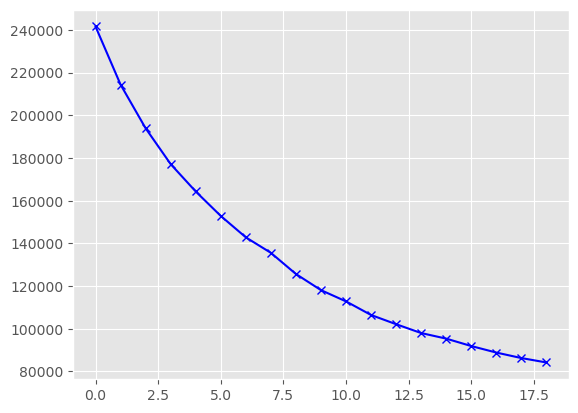

In [23]:
optimal_k_value = finding_best_k(creditcard_df_scaled)

In [ ]:
#optimal_k_value = finding_best_k(creditcard_df_scaled[:,:7])

From this we can observe that, `6th cluster` seems to be forming the elbow of the curve. However, the values does not reduce linearly until 8th cluster. Let's choose the number of clusters to be 7 or 8.

#### 3.4 Implementing K-Means Algorithm

In [ ]:
def kmeans_clustering(optimal_k, data):
    """
    Args: optimal_k (_type_): Optimal value of K
          data (_type_): scaled data

    Returns: _type_: kmeans, labels, cluster_center
    """
    kmeans = KMeans(n_clusters = optimal_k, random_state=42)
    kmeans.fit(data)
    
    ## Cluster labels: (output) stored at index value (wrt orginal data)
    labels = kmeans.labels_
    #labels = kmeans.fit_predict(data)
    
    ## Cluster centers
    cluster_center = kmeans.cluster_centers_
    
    # Evaluation Metrics
    silhouette_raw = silhouette_score(data, labels)
    inertia_raw = kmeans.inertia_
    
    print("Optimal number of Clusters selected:", optimal_k)
    print('Shape of Clusters formed:', kmeans.cluster_centers_.shape)
    print(f"For KMeans, Silhouette Score: {silhouette_raw:.3f}, Inertia: {inertia_raw:.2f}")
    
    return kmeans, labels, cluster_center

In [25]:
kmeans_model, labels, cluster_center = kmeans_clustering(optimal_k = optimal_k_value, data = creditcard_df_scaled)

Optimal number of Clusters selected: 9
Shape of Clusters formed: (9, 27)
For KMeans, Silhouette Score: 0.171, Inertia: 125665.82


In [26]:
cluster_centers_df = pd.DataFrame(data = cluster_center, columns = creditcard_df.columns)

# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers_df = scaler.inverse_transform(cluster_centers_df)
cluster_centers_df = pd.DataFrame(data = cluster_centers_df, columns = creditcard_df.columns)
cluster_centers_df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_USAGE_RATIO,ONEOFF_PURCHASE_RATIO,INSTALLMENT_PURCHASE_RATIO,TOTAL_PURCHASES,PURCHASES_PER_TRX,CASH_ADVANCE_PER_TRX,PAYMENT_RATIO,MINIMUM_PAYMENT_RATIO,FULL_PAYMENT_FLAG,UTILIZATION_RATIO
0,2747.617956,0.985761,585.272651,75.734458,509.538193,639.259628,4.894122e-01,0.031490,0.465042,0.078587,2.289157,15.192771,2862.650602,971.586174,17742.092534,0.005111,11.915663,1.059239,0.137209,0.597731,585.272651,42.247626,136.132643,0.428211,7.755698,-6.938894e-18,0.463104
1,4964.367433,0.965168,525.036314,317.518216,207.626720,5176.532852,3.197825e-01,0.147328,0.210208,0.501149,15.400641,8.345085,8095.304002,4007.744285,1739.699620,0.038100,11.430556,0.627185,0.369042,71528.009940,525.144936,56.219766,674.001710,0.607459,0.238191,1.068376e-03,0.839266
2,1407.277465,0.844506,46.595980,4.812964,41.984632,1040.103569,6.931158e-02,0.005267,0.058223,0.193701,3.773969,0.988421,3119.597553,1017.152204,634.943404,0.033161,11.380269,0.519723,0.022364,9263.775253,46.797596,12.228989,345.053243,0.409716,0.270045,-6.245005e-17,0.430276
3,659.221965,0.888114,809.855994,174.362947,635.950054,166.920707,8.425465e-01,0.102029,0.788352,0.037043,0.697363,17.401842,3496.095848,972.282198,476.057344,0.208047,11.579322,0.257033,0.143487,0.857946,810.313001,51.596197,56.913974,0.393837,0.245494,-1.665335e-16,0.410342
4,5124.297838,0.954278,23582.410294,16487.660000,7094.750294,1640.157005,8.941176e-01,0.729412,0.749020,0.073529,3.235294,135.058824,15620.588235,23962.007525,3108.473940,0.500907,11.941176,0.359067,0.636793,0.363207,23582.410294,559.817606,142.305836,1.763463,0.208717,2.647059e-01,1.889767
5,795.497557,0.909091,0.000000,0.000000,0.000000,5676.779668,-5.551115e-17,0.000000,0.000000,0.500000,6.000000,0.000000,50.000000,7570.207782,410.260506,0.444444,12.000000,15.909951,0.000000,0.000000,0.000000,0.000000,946.129945,151.404156,8.205210,0.000000e+00,113.535593
6,1051.738412,0.841207,730.045681,668.540226,61.707190,334.983886,3.815004e-01,0.332368,0.083193,0.073738,1.386610,8.120698,4018.086094,1093.292893,505.775037,0.064587,11.528053,0.355883,0.933344,0.067150,730.247416,152.633374,103.350599,0.400095,0.208147,-6.938894e-17,0.400476
7,122.471387,0.754260,1263.724541,679.543428,584.246616,78.758125,6.862778e-01,0.280331,0.495339,0.014703,0.314410,17.539301,4801.360990,1676.987402,162.134372,1.000000,11.192140,0.035616,0.338262,0.607292,1263.790044,80.226006,40.310197,0.532272,0.057774,1.000000e+00,0.401111
8,2668.797775,0.986164,4517.958739,2967.622939,1551.116034,533.461409,9.523213e-01,0.725905,0.765280,0.079472,1.894668,63.751625,7894.148244,4228.505167,1134.522048,0.206211,11.916775,0.351304,0.642895,0.357244,4518.738973,98.616337,134.129430,0.705695,0.169620,2.600780e-02,0.833810


In [27]:
# concatenate the clusters labels to our original dataframe
creditcard_df_cluster = pd.concat([creditcard_df, pd.DataFrame({'cluster':labels})], axis = 1)
creditcard_df_cluster.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_USAGE_RATIO,ONEOFF_PURCHASE_RATIO,INSTALLMENT_PURCHASE_RATIO,TOTAL_PURCHASES,PURCHASES_PER_TRX,CASH_ADVANCE_PER_TRX,PAYMENT_RATIO,MINIMUM_PAYMENT_RATIO,FULL_PAYMENT_FLAG,UTILIZATION_RATIO,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0.040901,0.0,1.0,95.40,47.700000,0.000000,0.201802,0.139510,0,0.095400,2
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0.457495,0.0,0.0,0.00,0.000000,1610.736371,0.586148,0.153191,0,0.920421,1
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0.332687,1.0,0.0,773.17,64.430833,0.000000,0.082942,0.083638,0,0.103089,6
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0.222223,1.0,0.0,1499.00,1499.000000,205.788017,0.000000,0.115228,0,0.227305,6
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0.681429,1.0,0.0,16.00,16.000000,0.000000,0.565279,0.203993,0,0.013333,6


#### Insights

1. First Customers cluster (Transactors): Those are customers who pay least amount of intrerest charges and careful with their money, Cluster with lowest balance ($104) and cash advance ($303), Percentage of full payment = 23%
2. Second customers cluster (revolvers) who use credit card as a loan (most lucrative sector): highest balance ($5000) and cash advance (~$5000), low purchase frequency, high cash advance frequency (0.5), high cash advance transactions (16) and low percentage of full payment (3%)
3. Third customer cluster (VIP/Prime): high credit limit $16K and highest percentage of full payment, target for increase credit limit and increase spending habits
4. Fourth customer cluster (low tenure): these are customers with low tenure (7 years), low balance 

### 4. Understanding and applying PCA

* Rule of thumb: Retain >90% variance for most clustering use cases.

In [ ]:
def applying_pca(no_of_components, data):
    """
    Args: no_of_components (_type_): number of components to consider for pca
          data (_type_): scaled data

    Returns: _type_: principal_comp instance
    """
    pca = PCA(n_components = no_of_components)
    principal_comp = pca.fit_transform(data)
    print(principal_comp, '\n')
    
    print("Number of principal components:", no_of_components)
    # Explained variance
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    # Total Variance captured
    print("Total variance retained:", sum(pca.explained_variance_ratio_))
    
    return principal_comp

In [29]:
principal_comp_14 = applying_pca(no_of_components = 14, data = creditcard_df_scaled)

[[-1.73225058 -1.35911391 -0.04095889 ... -0.40529043 -0.23880302
  -0.14476914]
 [-1.49440929  2.74120139 -1.19743625 ... -0.07980141 -0.90470641
  -0.08126354]
 [ 0.98427024 -0.51641079 -0.7426931  ... -0.19289493  0.49681067
  -0.10541358]
 ...
 [-1.09396632 -2.05718525  0.41516194 ...  0.57070565  0.64569715
  -1.25123606]
 [-2.31040285 -1.09694728 -0.52863888 ... -0.02944893  0.82565899
  -0.79167561]
 [-0.19258768 -0.44251872 -0.74797494 ... -0.77610525  1.0342625
   0.24988922]] 

Number of principal components: 14
Explained variance ratio: [0.20916711 0.14969319 0.08540451 0.07516684 0.06967596 0.0555202
 0.04723709 0.04062327 0.03692014 0.03687901 0.03255802 0.03127339
 0.02595116 0.01880371]
Total variance retained: 0.9148735950304668


In [ ]:
# Create a dataframe with the 14 components
pca_df = pd.DataFrame(data = principal_comp_14, 
        columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9', 'pca10', 'pca11', 'pca12', 'pca13','pca14'])

# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
print("shape of PCA: ", pca_df.shape)
pca_df.head()

shape of PCA:  (8950, 15)


,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,cluster
0,-1.732251,-1.359114,-0.040959,0.089674,-0.327873,0.383760,0.912782,-0.033741,0.192756,-0.689366,-0.312434,-0.405290,-0.238803,-0.144769,2
1,-1.494409,2.741201,-1.197436,0.077024,1.557099,0.933283,0.610303,1.826014,-0.699494,0.612862,-0.559155,-0.079801,-0.904706,-0.081264,1
2,0.984270,-0.516411,-0.742693,-0.015680,-2.034355,-1.667700,-1.411123,1.059915,-0.437243,0.707077,0.298439,-0.192895,0.496811,-0.105414,6
3,0.441838,-0.243804,-2.705589,2.701474,-3.595951,2.550489,0.732935,-0.879750,0.352774,-0.542683,3.454472,5.452419,-0.847320,1.100521,6
4,-1.490216,-0.431025,0.102612,0.651687,-1.716329,-0.453489,-0.222148,0.296984,0.105528,-0.447478,-0.783892,-0.046701,-0.309453,0.373793,6


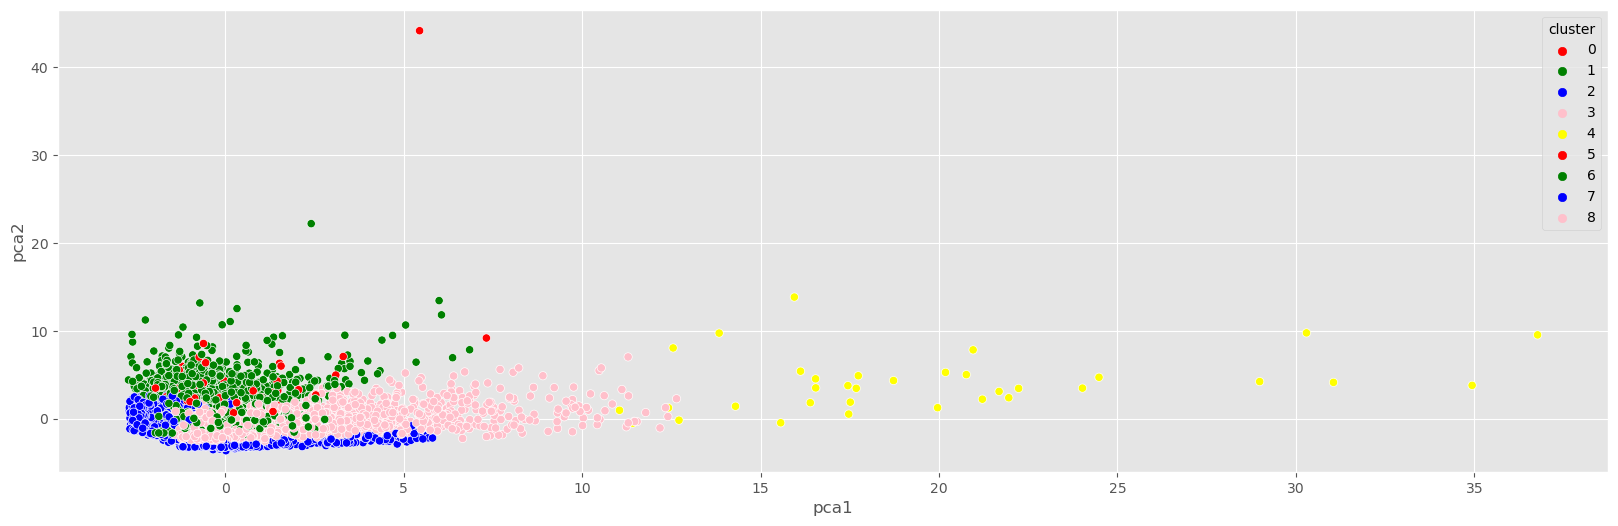

In [31]:
## Ploting for the top 2 Principal components
plt.figure(figsize=(20,6))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','pink','yellow'])
plt.show()
ax.get_figure().savefig("Images/PCA.jpeg")

In [32]:
kmeans_model_pca_14, labels_pca_14, cluster_center_pca_14 = kmeans_clustering(optimal_k = optimal_k_value, data = principal_comp_14)

Optimal number of Clusters selected: 9
Shape of Clusters formed: (9, 14)
For KMeans, Silhouette Score: 0.183, Inertia: 105474.41


#### Appyling Kmeans on PCA data (Top 3 Principal Components)

In [34]:
# Apply pca to get the principal components (3 in our case)
principal_3_comp = applying_pca(no_of_components = 3, data = creditcard_df_scaled)

# Apply Kmeans to get Silhoutte score and Inertia for Evaluation
kmeans_model_pca_3, labels_pca_3, cluster_center_pca_3 = kmeans_clustering(optimal_k = optimal_k_value, data = principal_3_comp)

[[-1.73225289 -1.35914101 -0.04090546]
 [-1.49441439  2.74119803 -1.1973595 ]
 [ 0.98426718 -0.51646783 -0.742211  ]
 ...
 [-1.09398571 -2.05730154  0.41437782]
 [-2.31042636 -1.09707653 -0.52862085]
 [-0.19259393 -0.44253248 -0.74761905]] 

Number of principal components: 3
Explained variance ratio: [0.20916711 0.14969319 0.08540449]
Total variance retained: 0.44426478953724874
Optimal number of Clusters selected: 9
Shape of Clusters formed: (9, 3)
For KMeans, Silhouette Score: 0.289, Inertia: 25465.82


#### Compare Cluster assignment before and after PCA
Evaluation:
* How similar the cluster groupings are, despite PCA altering the data.
* High ARI/NMI = PCA preserved the structure well.

In [ ]:
def Cluster_comp_before_after_pca(principal_comp, labels_pca):
    """
    Args: principal_comp (_type_): number of principal components
          labels_pca (_type_): labels of pca clusters
    """
    
    print('principal coponents:', principal_comp)
    
    # Compare cluster assignments using a contingency table
    column_name = f'PCA_Clusters_{principal_comp}_Comp'
    comparison_df = pd.DataFrame({'Original_Clusters': labels, column_name: labels_pca})
    
    confusion_matrix = pd.crosstab(comparison_df['Original_Clusters'], comparison_df[column_name])
    
    print("Cluster Comparison Table (Original vs PCA):\n")
    print(confusion_matrix)
    
    # Adjusted Rand Index: Perfect match = 1.0, random = ~0.0
    ari = adjusted_rand_score(labels, labels_pca)
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")

    # Normalized Mutual Information: Measures shared information (0 to 1)
    nmi = normalized_mutual_info_score(labels, labels_pca)
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

In [44]:
# Comparision of original cluster with 14 principal components
Cluster_comp_before_after_pca(principal_comp = 14, labels_pca = labels_pca_14)

principal coponents: 14
Cluster Comparison Table (Original vs PCA):

PCA_Clusters_14_Comp    0     1  2     3  4   5   6    7    8
Original_Clusters                                            
0                       0     0  0     0  0   0  83    0    0
1                      13     0  0     1  1   0   0  922    0
2                       0    33  0  1903  0   0   0  223    0
3                     212  2121  0    50  0   0   0    5    0
4                       0     0  0     0  0  34   0    0    0
5                       0     0  1     0  0   0   0    0    0
6                     471    36  0  1594  0   0   0   20    0
7                       0     0  0     0  0   0   0    0  458
8                     699     0  0     0  0  51   0    6   13
Adjusted Rand Index (ARI): 0.569
Normalized Mutual Information (NMI): 0.687


In [45]:
# Comparision of original cluster with 3 principal components
Cluster_comp_before_after_pca(principal_comp = 3, labels_pca = labels_pca_3)

principal coponents: 3
Cluster Comparison Table (Original vs PCA):

PCA_Clusters_3_Comp     0    1    2    3   4  5    6     7    8
Original_Clusters                                              
0                       0    0    4   79   0  0    0     0    0
1                       0    4  692   21   0  0    5   215    0
2                       2    0    0   49   0  0    1  1642  465
3                    1344    0    0  454   0  0  280    43  267
4                       0    5    0    0  29  0    0     0    0
5                       0    0    0    0   0  1    0     0    0
6                     247    0   10   92   0  0  245   550  977
7                     234    6    1    0   0  0  127     0   90
8                       0  258    4   14   0  0  493     0    0
Adjusted Rand Index (ARI): 0.338
Normalized Mutual Information (NMI): 0.456


#### Saving Results (Original Data + PCA based cluster labels)

Create a new DataFrame with original (unscaled) data + PCA-based cluster labels

In [ ]:
# original data
creditcard_df_unscaled = pd.DataFrame(scaler.inverse_transform(creditcard_df_scaled), columns=creditcard_df.columns)

# Adding PCA labels (3 comp and 14 comp)
creditcard_df_unscaled['cluster_without_pca'] = labels
creditcard_df_unscaled['cluster_pca_14_comp'] = labels_pca_14
creditcard_df_unscaled['cluster_pca_3_comp'] = labels_pca_3
creditcard_df_unscaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_USAGE_RATIO,ONEOFF_PURCHASE_RATIO,INSTALLMENT_PURCHASE_RATIO,TOTAL_PURCHASES,PURCHASES_PER_TRX,CASH_ADVANCE_PER_TRX,PAYMENT_RATIO,MINIMUM_PAYMENT_RATIO,FULL_PAYMENT_FLAG,UTILIZATION_RATIO,cluster_without_pca,cluster_pca_14_comp,cluster_pca_3_comp
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,1.666670e-01,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,0.040901,0.0,1.0,95.40,47.700000,0.000000,0.201802,0.139510,0.0,0.095400,2,3,8
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,-5.551115e-17,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,0.457495,0.0,0.0,0.00,0.000000,1610.736371,0.586148,0.153191,0.0,0.920421,1,7,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,0.332687,1.0,0.0,773.17,64.430833,0.000000,0.082942,0.083638,0.0,0.103089,6,0,6
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,8.333300e-02,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,864.206542,0.000000,12.0,0.222223,1.0,0.0,1499.00,1499.000000,205.788017,0.000000,0.115228,0.0,0.227305,6,3,8
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,8.333300e-02,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,0.681429,1.0,0.0,16.00,16.000000,0.000000,0.565279,0.203993,0.0,0.013333,6,3,8


In [47]:
creditcard_df_unscaled.to_csv('./data/creditcard_df_clustered_w_features.csv', index = False)

### Interpretation of the result and which Cluster to choose? (Orginal without PCA, PCA with 14 components, or PCA with 3 components)

| Approach | Silhouette | Inertia | ARI | NMI |
| ------------------ | ---------- | --------- | ----- | ----- |
| **Original** | 0.171 | 125665.82 | — | — |
| **PCA (14 comps)** | 0.183 | 105474.41 | 0.569 | 0.687 |
| **PCA (3 comps)** | 0.289 | 25465.82 | 0.338 | 0.456 |

1. Silhouette Score:
* Best is PCA (3 components) → 0.289
* Higher Silhouette means better separation and cohesion.

2. Inertia:
* Lowest (i.e., best) again for PCA (3 components) → 25,465.82
* Indicates tighter clusters.

3. ARI & NMI:
* PCA (3) captures compact clusters, but loses alignment with the original label structure. (ARI = 0.338, NMI = 0.456)
* PCA (14) preserves more meaningful information for matching true labels. (ARI = 0.569, NMI = 0.687)

### Recommendation:

Based on evaluation metrics, clustering using PCA with 3 components is optimal. It significantly improves Silhouette Score and Inertia, while still maintaining a `decent` match with original clusters (via ARI/NMI). This suggests PCA with 3 components enhances clustering performance and interpretability.

| If your goal is                                                                         | Use this version                    |
| --------------------------------------------------------------------------------------- | ----------------------------------- |
| **Compact, well-separated clusters** (e.g., marketing personas without known labels)    | **PCA (3 components)**              |
| **Better alignment with known labels / ground truth** (e.g., customer churn categories) | **PCA (14 components)**             |
| **Full feature fidelity**, but slightly worse cluster quality                           | **Original** (not recommended here) |